In [1]:
import numpy as np

from keras.layers import Input # define the input shape for the model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D # for the convnet structure
from keras.models import Model # for the overall definition

from keras import regularizers

from utils import compute_spectrogram

In [3]:
# general parameters
INPUT_FILE = 'samples/Jarrett_Vienna_cut.wav'           # input file for feature evaluation
SR = 44100                                              # sampling rate
NO_MELS = 128                                           # no. of mel bins
FFT_SIZE = 1024                                         # size of FFT
HOP_SIZE = 512                                          # hop size (overlap)
DURATION = 30                                           # segment duration (sec)

In [30]:
# load the training dataset
# obs: incomplete version
dataset = np.load('dataset_test.npz','r')
data_training = dataset['dataset']
data_training = np.transpose(data_training)
print('Training dataset with shape', data_training.shape)
print('Batch size:', data_training.shape[0])

Training dataset with shape (319, 2584, 128)
Batch size: 319


In [3]:
# Convolutional autoencoder structure using the Model API
# define input shape
input_img = Input(shape=(2584,128,1))
print('Some information about tensor expected shapes')
print('Input tensor shape:', input_img.shape)

# define encoder convnet
x = Conv2D(filters=128,kernel_size=(4,4),activation='relu',padding='same',activity_regularizer=regularizers.l1(1e-5))(input_img)
x = MaxPooling2D(pool_size=(2,2),strides=(2),padding='same')(x)
x = Conv2D(filters=256,kernel_size=(4,4),activation='relu',padding='same',activity_regularizer=regularizers.l1(1e-5))(x)
x = MaxPooling2D(pool_size=(2,2),strides=(2),padding='same')(x)
x = Conv2D(filters=512,kernel_size=(4,4),activation='relu',padding='same',activity_regularizer=regularizers.l1(1e-5))(x)
encoded = MaxPooling2D(pool_size=(2,2),strides=(2),padding='same')(x)
print('Encoded representation tensor shape:', encoded.shape)

# define decoder convnet
x = Conv2D(filters=512,kernel_size=(4,4),activation='relu',padding='same')(encoded)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=256,kernel_size=(4,4),activation='relu',padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=128,kernel_size=(4,4),activation='relu',padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
decoded = Conv2D(filters=1,kernel_size=(4,4),activation='linear',padding='same')(x)
print('Decoded representation tensor shape:', decoded.shape)

# define overal autoencoder model
cae = Model(inputs=input_img, outputs=decoded)
cae.compile(optimizer='adam', loss='mse')

# check for equal size
# obs: the missing value is the batch_size
if input_img.shape[1:] != decoded.shape[1:]: print('alert: in/out dimension mismatch')

Some information about tensor expected shapes
Input tensor shape: (?, 2584, 128, 1)
Encoded representation tensor shape: (?, 323, 16, 512)
Decoded representation tensor shape: (?, 2584, 128, 1)


In [5]:
# using the Tensorboard web interface
#from keras.callbacks import TensorBoard

# reshape the training set in 4-dimension tensor
data_training = np.reshape(data_training, (len(data_training), data_training.shape[1], data_training.shape[2], 1))
print('Data training reshaping in tensor of shape', data_training.shape)


cae.fit(data_training,data_training,
        epochs=1,
        batch_size=4, # minibatch of 4 for memory optimisation
        #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
       )

Data training reshaping in tensor of shape (140, 2584, 128, 1)
Epoch 1/1
140/140 [==============================] - 5899s - loss: 135099.2583      

In [4]:
def compute_specs(audiofile, no_mels, fft_size, hop_size, duration):
    [y, sr] = librosa.core.load(audiofile, sr=None, mono=True)

    # get audio file for desired duration
    len = sr * duration
    y = y[0:len]

    # get options for computing spectrogram
    mels = no_mels                      # frequency resolution
    fft = fft_size                      # fft length
    hop = hop_size                      # hop size

    # Mel spectrogram for the file, overlap=50%
    S = librosa.feature.melspectrogram(y, sr, n_fft=fft, n_mels=mels, hop_length=hop)
    # log-compressed version
    S = librosa.power_to_db(S, ref=np.max)

    # get spectrogram matrix dimensions (to be used in the convnet)
    dims = S.shape

    # plot the spectrogram

    fig = plt.figure(figsize=[12, 4])
    librosa.display.specshow(S, sr=sr, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()
    fig.savefig('Original Mel spectrogram')

    return S, dims

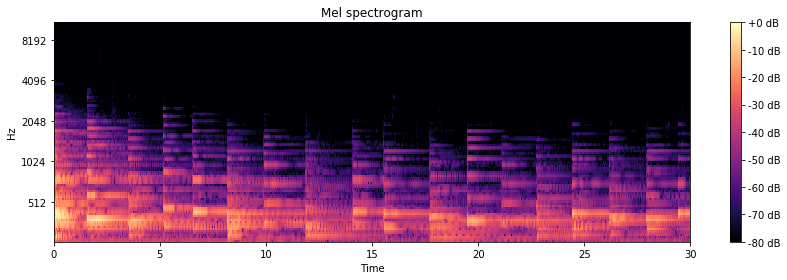

Test spectogram of shape (1, 2584, 128, 1)
Decoded image dimensions: (1, 2584, 128, 1)
Decoded image after reshaping: (128, 2584)


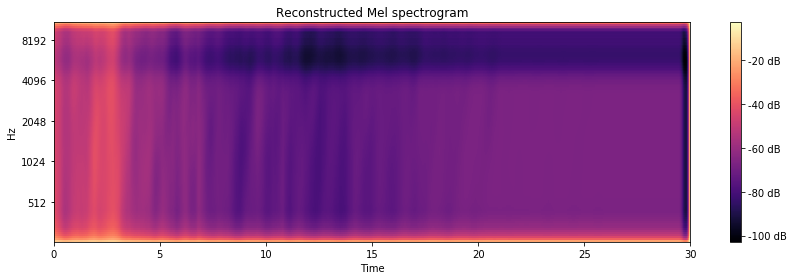

Image saved.


In [45]:
# get the reconstruction from a test audio file
import matplotlib.pyplot as plt
import librosa
import librosa.display 

[S, dims] = compute_specs(
            audiofile=INPUT_FILE,
            no_mels=NO_MELS,
            fft_size=FFT_SIZE,
            hop_size=HOP_SIZE,
            duration=DURATION,
        )

# create a test spectrogram
data_test = S.transpose()
data_test = np.reshape(S,newshape=(1, data_test.shape[0], data_test.shape[1], 1))
print('Test spectogram of shape', data_test.shape)
# spectrogram prediction
decoded_img = cae.predict(data_test)
print('Decoded image dimensions:', decoded_img.shape)

# reshape decoded_img in a 2D spectrogram
decoded_img = np.reshape(decoded_img,newshape=(2584,128))
decoded_img = decoded_img.transpose()
print('Decoded image after reshaping:',decoded_img.shape)


# display reconstruction
fig = plt.figure(figsize=[12, 4])
librosa.display.specshow(decoded_img, sr=SR, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed Mel spectrogram')
plt.tight_layout()
plt.show()

# to save the image
fig.savefig('reconstruction.png')
print('Image saved.')

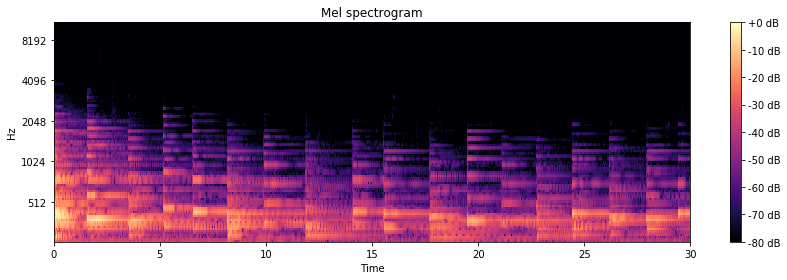

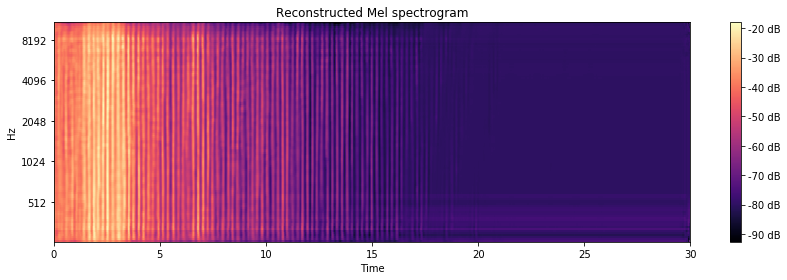

In [6]:
# load spectogram
reconstruction = np.load('reconstruction.npy')

# create spectrogram from the audio file
import matplotlib.pyplot as plt
import librosa
import librosa.display 

[S, dims] = compute_specs(
            audiofile=INPUT_FILE,
            no_mels=NO_MELS,
            fft_size=FFT_SIZE,
            hop_size=HOP_SIZE,
            duration=DURATION,
        )

# display reconstruction
fig = plt.figure(figsize=[12, 4])
librosa.display.specshow(reconstruction, sr=SR, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed Mel spectrogram')
plt.tight_layout()
plt.show()